In [1]:
import os
import torch
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
from typing import Type
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pkgs import dataprepare
from pkgs import legacytraining
from pkgs import neuralnet


In [ ]:
class UrbanGreenSegmentation(pl.LightningModule):
    def __init__(self, rotate_training_data : bool = False, train_ratio : float = 0.8, patch_size : int = 100, batch_size : int = 4, region:str = 'N12'):
        super(UrbanGreenSegmentation, self).__init__()
        raw_data_array, OHE_target_array, raw_target_array = dataprepare.prepare_raw_files(region)
        self.batch_size = batch_size
        self.Datasets = {
            'Train' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
            'Validation' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
            'Prediction' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
        }

        self.Dataloaders = {
            'Train' : DataLoader(self.Datasets['Train'], batch_size=batch_size),
            'Validation' : DataLoader(self.Datasets['Validation'], batch_size=batch_size),
            'Prediction' : DataLoader(self.Datasets['Prediction'], batch_size=batch_size)
        }
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet()
        self.regression = neuralnet.Splitted_Regression()
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=7)
        self.bn1 = nn.BatchNorm2d(7)
        self.bn2 = nn.BatchNorm2d(14)
        self.fc2 = nn.Conv2d(in_channels=14, out_channels=7)
        self.softmax = nn.Softmax2d()

    def forward(self, x_seg, x_reg):
        x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        x_seg = torch.cat((x_reg, x_seg), dim=1)
        x_seg = self.bn2(x_seg)
        x_seg = self.fc2(x_seg)
        x_seg = self.softmax(x_seg)
        return x_seg


    def training_step(self, batch, batch_idx):
        x_seg, x_reg, y_seg, _ = batch
        y_hat = self(x_seg, x_reg)
        return {'loss' : F.cross_entropy(y_hat, y_seg)}

    def validation_step(self, batch, batch_idx):
        x_seg, x_reg, y_seg, _ = batch
        y_hat = self(x_seg, x_reg)
        return {
            'valid_loss' : F.cross_entropy(y_hat, y_seg),
            'y_hat' : y_hat.detach(),
            'y' : y_seg.detach()
        }

    def predict_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        train_optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(train_optimizer, T_max=10)
        return [train_optimizer], [train_scheduler]

    def train_dataloader(self):
        return DataLoader(self.Datasets['Train'], batch_size = self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.Datasets['Validation'], batch_size = self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.Datasets['Prediction'], batch_size = self.batch_size)

In [ ]:
class UrbanGreenSegmentation(nn.Module):
    def __init__(self, device = 'cuda:0'):
        super(UrbanGreenSegmentation, self).__init__()
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet()
        self.regression = neuralnet.Splitted_Regression(device=device)
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=7, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(7)
        self.bn2 = nn.BatchNorm2d(14)
        self.fc2 = nn.Conv2d(in_channels=14, out_channels=7, kernel_size=1)
        self.softmax = nn.Softmax2d()

    def forward(self, x_seg, x_reg):
        x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        x_seg = torch.cat((x_reg, x_seg), dim=1)
        x_seg = self.bn2(x_seg)
        x_seg = self.fc2(x_seg)
        x_seg = self.softmax(x_seg)
        return x_seg


In [2]:
class UrbanGreenSegmentation2(nn.Module):
    def __init__(self, in_channel:int=6, out_channel:int=7):
        super(UrbanGreenSegmentation2, self).__init__()
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet(in_channel=in_channel)
        #self.regression = neuralnet.Splitted_Regression()
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        #self.bn2 = nn.BatchNorm2d(14)
        #self.fc2 = nn.Conv2d(in_channels=14, out_channels=7, kernel_size=1)
        self.softmax = nn.Softmax2d()

    def forward(self, x_seg):
        #x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        #x_seg = torch.cat((x_reg, x_seg), dim=1)
        #x_seg = self.bn2(x_seg)
        #x_seg = self.fc2(x_seg)
        x_seg = self.softmax(x_seg)
        return x_seg


In [4]:
gpus = 7 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

raw_data_array_N12 ,raw_target_array_N12, OHE_target_array_N12 = dataprepare.prepare_raw_files('N12')
raw_data_array_H19 ,raw_target_array_H19, OHE_target_array_H19 = dataprepare.prepare_raw_files('H19')
raw_data_array_M18 ,raw_target_array_M18, OHE_target_array_M18 = dataprepare.prepare_raw_files('M18')

raw_data_array = np.concatenate((raw_data_array_N12, raw_data_array_H19, raw_data_array_M18), axis=-1)
print(raw_data_array.shape)
raw_target_array = np.concatenate((raw_target_array_N12, raw_target_array_H19, raw_target_array_M18), axis=-1)
print(raw_target_array.shape)
OHE_target_array = np.concatenate((OHE_target_array_N12, OHE_target_array_H19, OHE_target_array_M18), axis=-1)
batch_size = 4
patch_size = 100
train_ratio = 0.8
rotate_training_data = False


Preexisting Data Found. Load from it?
Preexisting Data Found. Load from it?
Preexisting Data Found. Load from it?
(6, 2400, 7200)
(2400, 7200)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(raw_target_array[0:100, 100:200])

In [ ]:
Datasets_ver3 = {
    'Train' : dataprepare.TrainDataset4(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
    'Validation' : dataprepare.TrainDataset4(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
    'Prediction' : dataprepare.TrainDataset4(raw_data_array_H19, OHE_target_array_H19, raw_target_array_H19, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
}
Dataloaders_ver3 = {
    'Train' : DataLoader(Datasets_ver3['Train'], batch_size=batch_size),
    'Validation' : DataLoader(Datasets_ver3['Validation'], batch_size=batch_size),
    'Prediction' : DataLoader(Datasets_ver3['Prediction'], batch_size=2)
}
model = UrbanGreenSegmentation()
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=5, factor=0.75)

In [ ]:
regmodel = neuralnet.Splitted_Regression(device='cpu')
for idx, i in enumerate(Dataloaders_ver3['Train']):
    a,b,c,d = i
    #res = regmodel(b)
    #plt.figure(figsize=(3,3))
    #plt.imshow(res[0,0,:,:].detach().numpy())
    plt.figure(figsize=(3,3))
    print(a.shape)
    plt.imshow(c[0,:,:])
    if idx > 10:
        break

In [ ]:
print(device)

best_model_path = legacytraining.train_model(model, dataloaders=Dataloaders_ver3, criterion=criterion3, num_epochs = 100, optimizer=optimizer3, scheduler=scheduler3, path='../Data/N12/Model/Segmentation/', description='activate_regression_gradient', device=device)

In [ ]:
a,b,c,d = Dataloaders_ver3['Prediction'].dataset[0:2]
reg = neuralnet.Splitted_Regression(device='cpu')
res = reg(b)
plt.figure(figsize=(10,10))
plt.imshow(res[1,-1,:,:])

In [ ]:
model.to(device)
model.load_state_dict(torch.load('/home/bcyoon/Byeongchan/Data/N12/Model/Segmentation/2022.8.3/Best_Model_Parameters_of_11:56_cross_entropy_test.pth'))
reference_data = '/home/bcyoon/Byeongchan/Data/H19/H19_lidar.tif'
result_path = legacytraining.save_result(model.to('cpu'), dataloader=Dataloaders_ver3['Prediction'], path='../Data/N12/Model/Segmentation/', description='H19_prediction', reference_data=reference_data, patch_size=100, device = device)

Preexisting Data Found. Load from it?
No Data Found. Loading from Raw Data
Not fitting. Trimming Data.
(576, 7)


Predicting...: : 288it [00:09, 29.90it/s]


Type yes to continue


Writing data: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


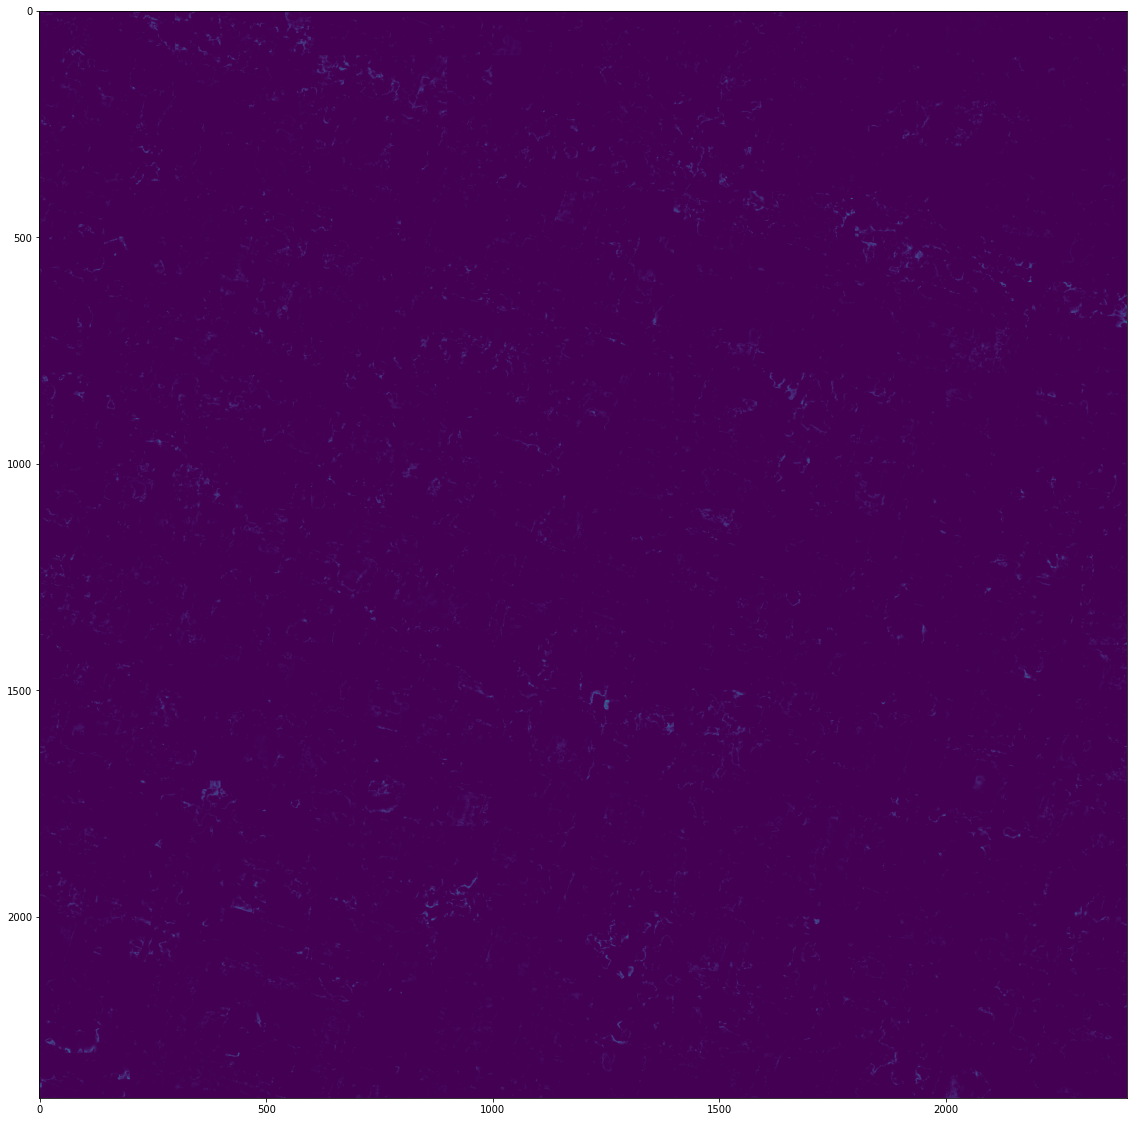

In [7]:
model2 = UrbanGreenSegmentation2()
model2.to(device)
model2.load_state_dict(torch.load('/home/bcyoon/Byeongchan/Data/Model/Segmentation/Categories_5/2022.8.5/Best_Model_Parameters_of_14:19_Categories_5.pth'))
raw_data_array_N11 ,raw_target_array_N11, OHE_target_array_N11 = dataprepare.prepare_raw_files('N11')
N11_prediction_dataset = dataprepare.TrainDataset4(raw_data_array_N11, OHE_target_array_N11, raw_target_array_N11, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
N11_prediction_dataloader = DataLoader(N11_prediction_dataset, batch_size=2)
reference_data = '/home/bcyoon/Byeongchan/Data/N11/N11_lidar.tif'
result_path = legacytraining.save_result2(model2.to('cpu'), dataloader=N11_prediction_dataloader, path='../Data/N11/Model/Segmentation/', description='bias_false', reference_data=reference_data, patch_size=100, device = device)